In [82]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [83]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')

In [84]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1,2,3]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

In [127]:
train_propre = train.dropna()

n=0.55
train_propre = train_propre[train_propre.RET_1  < n]
train_propre = train_propre[train_propre.RET_2  < n]
train_propre = train_propre[train_propre.RET_3  < n]
train_propre = train_propre[train_propre.RET_4  < n]
train_propre = train_propre[train_propre.RET_5  < n]
train_propre = train_propre[train_propre.RET_6  < n]
train_propre = train_propre[train_propre.RET_7  < n]
train_propre = train_propre[train_propre.RET_8  < n]
train_propre = train_propre[train_propre.RET_9  < n]
train_propre = train_propre[train_propre.RET_10 < n]
train_propre = train_propre[train_propre.RET_11 < n]
train_propre = train_propre[train_propre.RET_12 < n]
train_propre = train_propre[train_propre.RET_13 < n]
train_propre = train_propre[train_propre.RET_14 < n]
train_propre = train_propre[train_propre.RET_15 < n]
train_propre = train_propre[train_propre.RET_16 < n]
train_propre = train_propre[train_propre.RET_17 < n]
train_propre = train_propre[train_propre.RET_18 < n]
train_propre = train_propre[train_propre.RET_19 < n]
train_propre = train_propre[train_propre.RET_20 < n]

train_propre = train_propre.reset_index(drop=True)
#print(type(train_propre),type(x_train))
print(train_propre.shape,x_train.shape)
#print(train_propre.head(),x_train.head())

(66, 50) (418595, 46)


In [112]:
n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features

In [113]:
# import des fonctions keras nécessaires
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot

# Construction du modèle : 
def creation_model(len_input):
    
    model = Sequential()
    
    #inputs
    n_input = len_input
    model.add(Dense(10,activation='relu',input_shape=(n_input,)))

    #corps
    model.add(Dense(5,activation='relu',input_shape=(n_input,)))
    model.add(Dense(5,activation='relu',input_shape=(n_input,)))
    model.add(Dense(5,activation='relu',input_shape=(n_input,)))

    #output
    n_neurone_sortie = 2
    model.add(Dense(n_neurone_sortie,activation='softmax'))
    

    #model.summary()
    return model

In [114]:
X_train = np.asarray(train_propre[features])

from keras.utils import to_categorical 

y_train = to_categorical(train_propre.RET)

#print(type(X_train),type(y_train))
#print(X_train.shape,y_train.shape)
#print(X_train[0],y_train[0])

In [115]:
model = creation_model(len(features))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs = 40,
                     batch_size = 2000,
                     validation_split = 0.10,
                     verbose = 1,
                     callbacks=[es,mc])

Epoch 1/40
1/1 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4394
Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to best_model.h5
1/1 [==============================] - 0s 279ms/step - loss: 0.6945 - accuracy: 0.4394 - val_loss: 0.6935 - val_accuracy: 0.3750
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.4545
Epoch 00002: val_accuracy did not improve from 0.37500
1/1 [==============================] - 0s 21ms/step - loss: 0.6944 - accuracy: 0.4545 - val_loss: 0.6932 - val_accuracy: 0.3750
Epoch 3/40
1/1 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4394
Epoch 00003: val_accuracy did not improve from 0.37500
1/1 [==============================] - 0s 18ms/step - loss: 0.6942 - accuracy: 0.4394 - val_loss: 0.6930 - val_accuracy: 0.3750
Epoch 4/40
1/1 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4394
Epoch 00004: val_accuracy did not improve from 0.3

In [116]:
y_pred = model.predict(np.asarray(train[features]))
y_pred=y_pred[:,0]<y_pred[:,1]
y_train = pd.read_csv('y_train.csv', index_col='ID')
score = accuracy_score(y_train, y_pred)
print(f"Accuracy : {score* 100:.2f}%")

Accuracy : 50.39%


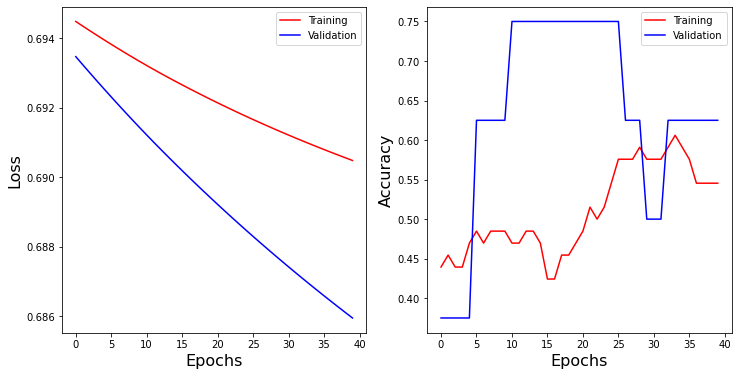

In [117]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

In [119]:
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,RET_1_SECTOR_DATE_mean,RET_2_SECTOR_DATE_mean,RET_3_SECTOR_DATE_mean
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True,0.009178,-0.017313,-0.000148
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True,0.006477,-0.023300,-0.008673
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False,0.013449,-0.045074,-0.011731
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False,0.017253,0.001304,-0.014219
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False,0.006241,-0.014918,-0.004146


In [128]:
features

['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'RET_1_SECTOR_DATE_mean',
 'RET_2_SECTOR_DATE_mean',
 'RET_3_SECTOR_DATE_mean']